## Paris roadspace

In [1]:
import pandas as pd
import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import osmnx as ox
import seaborn as sns

In [2]:
# Define paths
ITF_geospatial = 'C:/Users/marno/Documents/Python Projects/paris-roadspace/data/geospatial/ITF/'
APUR_geospatial = 'C:/Users/marno/Documents/Python Projects/paris-roadspace/data/geospatial/APUR/'
ox_geocode = 'Paris, France' 

## ITF data
The routable datafile for Ile de France.

### Convert coordinate reference system

In [3]:
def convert_crs(file, crs='epsg:4326') -> str():
    """Load file, convert to crs, save to same file with suffix, return path to clipped file"""
    
    # Load and convert
    orig = gpd.read_file(file+'.shp')
    new = orig.to_crs(crs)

    # Save to new file
    path = file+'_'+crs.replace(':','')+'.shp'
    new.to_file(path)
    
    return path

In [ ]:
convert_crs(APUR_geospatial+'Paris_Road network')

### Clip

In [144]:
paris = ox.geocode_to_gdf(ox_geocode) # The administrative boundaries of Paris according to OSM
clipped = gpd.clip(new, paris) # This keeps only the part of the road network contained with these boundaries
old_geom = new.loc[clipped.index].geometry
clipped.insert(11, 'changed', pd.Series(clipped.geometry != old_geom)) # mark roads that have changed shape due to clipping
clipped.to_file(FILE+'_clipped.shp', index=True) # Export

### Clean
...

### Load

oneway: B and F: Bidirectional and F... ? <br>

In [145]:
paris_roads = gpd.read_file(FILE+'_clipped.shp')

(2.213074358555878, 2.4819812703265267, 48.81127494063675, 48.906397571391054)

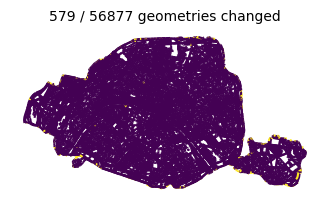

In [286]:
paris_roads.plot(column='changed', cmap='viridis', figsize=(4,4))
title = f'{paris_roads.changed.sum()} / {len(paris_roads)} geometries changed'
plt.title(title, fontsize=10)
plt.axis('off')

<b> TODO </b> <br> 
579 roads were changed, meaning values for lengths are outdated for these entries <br>
In the future, may be worth recomputing these values. For now, leaving them outside the dataset

In [291]:
paris_roads = paris_roads.drop(index=paris_roads.loc[paris_roads.changed==1].index)

### Explore

C:\Users\marno\AppData\Local\Temp\ipykernel_10488\227739890.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sum_by_type = paris_roads.groupby(by='fclass').sum()


<Axes: xlabel='length', ylabel='fclass'>

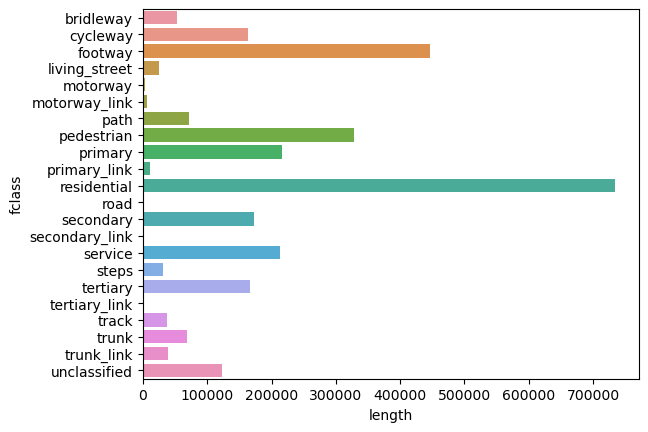

In [295]:
sum_by_type = paris_roads.groupby(by='fclass').sum()
sns.barplot(y=sum_by_type.index, x=sum_by_type.length, orient='h')

Graph excludes the roads that are cut off (yellow in the map), since length data does not automatically adjust 

## APUR data

### Convert coordinate reference system

In [167]:
# Choose file and crs to convert to
FILE1 = APUR_geospatial+'ilot_physique'
FILE2 = APUR_geospatial+'troncon_voie_largeur'

# Load and convert
orig1 = gpd.read_file(FILE1+'.shp')
orig2 = gpd.read_file(FILE2+'.shp')

path1 = convert_crs(FILE1)
path2 = convert_crs(FILE2)

(file1, _), (file2, _) = path1.split('.'), path2.split('.') # strip from extension

### Clip

In [180]:
phys = gpd.read_file(APUR_geospatial+'ilot_physique_epsg4326.shp')
voie = gpd.read_file(APUR_geospatial+'troncon_voie_largeur_epsg4326.shp')

In [275]:
paris = ox.geocode_to_gdf(ox_geocode) # The administrative boundaries of Paris according to OSM

for gdf, file, typ in zip([phys, voie], [file1, file2], ['poly','line']):
    col_num = len(gdf.columns)-1
    clipped = gpd.clip(gdf, paris) # This keeps only the part of the road network contained with these boundaries
    old_geom = gdf.loc[clipped.index].geometry
    if typ == 'poly':
        changed = pd.Series((not row.geometry.equals(old_geom[index]) for index, row in clipped.iterrows()), index=clipped.index)
    else:
        changed = pd.Series(clipped.geometry != old_geom, index=clipped.index)
    clipped.insert(col_num, 'changed', changed) # mark elements that have changed shape due to clipping
    clipped.to_file(file+'_clipped.shp', index=True) # Export

### Clean

In [436]:
# voie_clipped = gpd.read_file(APUR_geospatial+'troncon_voie_largeur_epsg4326_clipped.shp')

# # Clean road category typos
# voie_clipped.loc[(~voie_clipped.c_tvniv1.isin([10,20,30])), 'c_tvniv1'] = 20
# voie_clipped.loc[voie_clipped.c_tvniv2 == 210, 'c_tvniv2'] = 201
# voie_clipped.loc[voie_clipped.c_tvniv2 == 220, 'c_tvniv2'] = 202

# # save
# voie_clipped.to_file(APUR_geospatial+'troncon_voie_largeur_epsg4326_clipped.shp')

### Load

In [623]:
phys_clipped = gpd.read_file(APUR_geospatial+'ilot_physique_epsg4326_clipped.shp')
voie_clipped = gpd.read_file(APUR_geospatial+'troncon_voie_largeur_epsg4326_clipped.shp')

### Remove cut-off elements

In [624]:
phys_multi_changed = phys_clipped.loc[phys_clipped.geometry.geom_type == 'MultiPolygon'].changed.value_counts()
voie_multi_changed = voie_clipped.loc[voie_clipped.geometry.geom_type == 'MultiLineString'].changed.value_counts()
print(f'Phys:\n{phys_multi_changed}\n\nVoie:\n{voie_multi_changed}')

Phys:
1    25
Name: changed, dtype: int64

Voie:
1    13
Name: changed, dtype: int64


<b> TODO </b> <br> 
Apparently, all 25 MultiPolygons and all 13 MultiLineStrings were marked changed <br>
In the future, it may be worth checking if the 'changed' tracking accurately caught changes in Multi- shapes. 

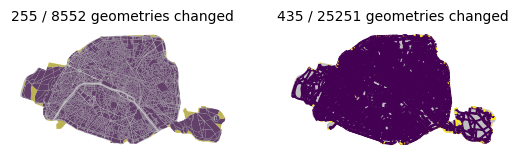

In [625]:
fig, ax = plt.subplots(1,2)
for ax, gdf in zip(ax, (phys_clipped, voie_clipped)):
    gdf.plot(column='changed', ax=ax)
    paris.plot(ax=ax, color='grey', alpha=0.5) # The administrative boundaries of Paris according to OSM
    ax.axis('off')
    sub = f'{gdf.changed.sum()} / {len(gdf)} geometries changed'
    ax.set_title(sub, fontsize=10)

<b> TODO </b> <br> 
255 areas and 435 roads were changed, meaning values for lengths and areas are outdated for these entries <br>
In the future, it may be worth recomputing these values. For now, leaving them outside the dataset

In [626]:
voie_clipped = voie_clipped.drop(index=voie_clipped.loc[voie_clipped.changed==1].index)
phys_clipped = phys_clipped.drop(index=phys_clipped.loc[phys_clipped.changed==1].index)

### Prepare roadtype legend

Prepare legend based on [link](https://geocatalogue.apur.org/catalogue/srv/fre/catalog.search#/metadata/urn:apur:troncon_voie_od)

In [627]:
codes = {'c_tvniv1': {'about': 'Hierarchical category Level 1. Hierarchical classification of the section in the simplified category (with 3 positions).',
                     'codes': {10: 'Regional infrastructure motorway',
                               20: 'Road part of the framework of the metropolitan territory',
                               30: 'Local route',
                     }},
 'c_tvniv2': {'about': 'Hierarchical category Level 2. hierarchical classification of the section in the detailed category (at 6 positions). Each level 1 category is broken down into a finer subcategory (level 2).',
              'codes': {101: 'Highway',
                        102: 'Ring road, Expressway, Bankway',
                        103: 'Lane with a motorway nature',
                        201: 'Major road structuring the city',
                        202: 'Organizing road structuring the neighborhood',
                        301: 'Local neighborhood road',
                        302: 'Private local road open to the public',
                        303: 'Pedestrian Way, Pedestrian Bridge',
              }},
    }

In [628]:
voie_clipped['c_tvniv1_t'] = voie_clipped.c_tvniv1.map(codes['c_tvniv1']['codes'])
voie_clipped['c_tvniv2_t'] = voie_clipped.c_tvniv2.map(codes['c_tvniv2']['codes'])

### Count elements

In [629]:
voie_clipped.c_tvniv1_t.value_counts()

Local route                                                 18547
Road part of the framework of the metropolitan territory     5010
Regional infrastructure motorway                             1259
Name: c_tvniv1_t, dtype: int64

In [630]:
voie_clipped.c_tvniv2_t.value_counts()

Local neighborhood road                         18215
Major road structuring the city                  3574
Organizing road structuring the neighborhood     1436
Ring road, Expressway, Bankway                   1167
Private local road open to the public             332
Highway                                            92
Name: c_tvniv2_t, dtype: int64

### Remove duplicates
Some are marked as duplicate. Need more info

In [631]:
voie_clipped = voie_clipped.drop(index=voie_clipped.loc[voie_clipped.b_voiedup == 'O'].index)

<b> TODO </b> <br> 
2.1% of the Paris network (% in terms of length) is marked as duplicate (B_VOIEDUP = O) <br>
Based on more info, may need to still use them. For now, leaving them outside the dataset

### Fill missing largeur values

In [632]:
print((voie_clipped.LARGEUR == 0.0).sum() / len(voie_clipped))
print(voie_clipped.loc[voie_clipped.LARGEUR == 0.0].Shape_Leng.sum() / voie_clipped.Shape_Leng.sum())

0.4744973632168754
0.36812524189083023


We miss width for 47% of elements <br>
This is 37% of total network length <br>
Let's look per category:

In [633]:
lengths_missing = voie_clipped.loc[voie_clipped.LARGEUR == 0.0].groupby(by='c_tvniv2_t').Shape_Leng.sum()
total_length = voie_clipped.Shape_Leng.sum()
lengths_all = voie_clipped.groupby(by='c_tvniv2_t').Shape_Leng.sum()

In [634]:
print('% of overall road length with missing largeur value:\n')
output = (lengths_missing / total_length).to_string(float_format='{:,.2%}'.format)
print(output)
print('% of road length within category with missing largeur value:\n')
output = (lengths_missing / lengths_all).to_string(float_format='{:,.2%}'.format)
print(output)

% of overall road length with missing largeur value:

c_tvniv2_t
Highway                                         0.34%
Local neighborhood road                        21.67%
Major road structuring the city                 8.11%
Organizing road structuring the neighborhood    1.78%
Private local road open to the public           0.33%
Ring road, Expressway, Bankway                  4.58%
% of road length within category with missing largeur value:

c_tvniv2_t
Highway                                        79.59%
Local neighborhood road                        29.09%
Major road structuring the city                63.05%
Organizing road structuring the neighborhood   32.55%
Private local road open to the public          25.43%
Ring road, Expressway, Bankway                 84.19%


Overall, most missing data comes from local neighborhood roads. 

In [640]:
# fig, ax = plt.subplots(1,2,figsize=(12,5))
# voie_clipped.loc[voie_clipped.LARGEUR>0].plot(column='c_tvniv2_t' ,ax=ax[0], legend=True)
# voie_clipped.loc[voie_clipped.LARGEUR==0.0].plot(column='c_tvniv2_t', ax=ax[1])
# for a in ax:
      # a.axis('off')
# plt.tight_layout()

In [635]:
available = voie_clipped.loc[(voie_clipped.LARGEUR > 0.0)].copy()
available['length_x_largeur'] = available.Shape_Leng * available.LARGEUR
length_x_largeur = available.groupby(by='c_tvniv2_t').length_x_largeur.sum()
total_lengths = available.groupby(by='c_tvniv2_t').Shape_Leng.sum()

In [636]:
print('Length-weighted average largeur value, per category:\n')
output = (length_x_largeur / total_lengths).to_string(float_format='{:.2f} m'.format)
print(output)

Length-weighted average largeur value, per category:

c_tvniv2_t
Highway                                        28.63 m
Local neighborhood road                        13.44 m
Major road structuring the city                32.72 m
Organizing road structuring the neighborhood   23.07 m
Private local road open to the public          10.65 m
Ring road, Expressway, Bankway                 50.04 m


Although most missing data comes from local neighborhood roads, these tend to be 13m wide, against 32m for major roads structure the city. Thus, based on surface area, it's both local neighborhood roads and major roads structuring the city that account for most of the data gap

<b> TODO </b> <br> 
Check the distribution of road widths per category to determine the validaty of filling with averages

<b> For now, let's fill the missing largeur data with averages per category </b>

In [637]:
voie_filled = voie_clipped.copy()

In [638]:
fills = {101: 35.74,
         102: 50.04,
        201: 32.51,
        202: 22.96,
        301: 13.52,
        302: 10.65,}

In [639]:
for key, value in fills.items():
    voie_filled.loc[(voie_filled.c_tvniv2 == key) & (voie_filled.LARGEUR == 0.0), 'LARGEUR'] = value

### Calculate total road space

In [643]:
total_m2 = (voie_filled.LARGEUR * voie_filled.Shape_Leng).sum()
total_m2

36446619.72603598

In [645]:
total_ha = 0.0001 * total_m2
print(f'{total_ha:2f} ha')

3644.661973 ha


vs. 2463 ha according to parking study

<b> Per type </b>

In [650]:
voie_filled['surface'] = voie_filled.LARGEUR * voie_filled.Shape_Leng
output = (voie_filled.groupby(by='c_tvniv2_t').surface.sum() * 0.0001).to_string(float_format='{:.0f} ha'.format)
print(output)

c_tvniv2_t
Highway                                          29 ha
Local neighborhood road                        1977 ha
Major road structuring the city                 826 ha
Organizing road structuring the neighborhood    249 ha
Private local road open to the public            27 ha
Ring road, Expressway, Bankway                  537 ha


### What about Phys?
I need this file to obtain true total public space

C:\Users\marno\AppData\Local\Temp\ipykernel_10488\4239572585.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sum_by_type = phys_clipped.groupby(by='d_c_type_i').sum()


Text(0.5, 0.98, 'Areas and lengths in phys dataset')

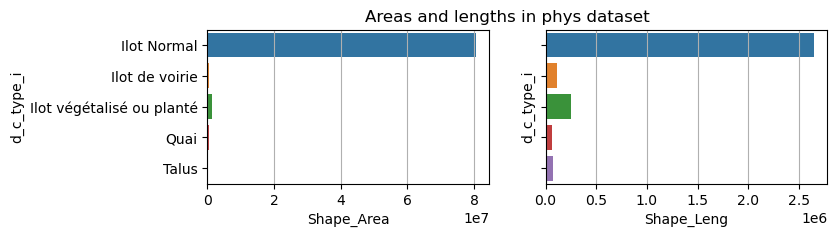

In [350]:
fig, ax = plt.subplots(1,2,sharey=True, figsize=(8,2))
sum_by_type = phys_clipped.groupby(by='d_c_type_i').sum()

for var, ax in zip(('Shape_Area','Shape_Leng'), ax):
    sns.barplot(y=sum_by_type.index, x=sum_by_type[var], orient='h', ax = ax)
    ax.xaxis.grid('on')

plt.suptitle('Areas and lengths in phys dataset')

Method: <br>
Docks, embankment

In [3]:
phys_clipped.plot()

NameError: name 'phys_clipped' is not defined